In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

%load_ext version_information

### Hauptkomponentenanalyse 

Vorgehen:
1. Gegeben eine Menge von $n$ $d$-dimensionalen Datenpunkten $\mathbf{x}_i$, berechnen Sie zuerst deren Mittelwert $\boldsymbol{\mu}_x = \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i$ für jedes einzelne Merkmal und ziehen ihn von allen Datenpunkten ab (Zentrierung).
2. Normieren Sie dann alle Merkmale so, dass sie eine Varianz von 1 haben. Dieser Schritt ist optional, aber meist vorteilhaft.
3. Kopieren Sie alle $\mathbf{x}_i$ als Reihen in eine $n \times d$-Matrix $X$, die sog. Daten- oder Designmatrix.
4. Zur Lösung des Eigenwertproblens berechnen Sie die Singulärwertzerlegung von $X$ (z.B. mit `numpy.linalg.svd()`): $$ X = UDV^\top $$
Wer nicht weiß, was eine Singuärwertzerlegung ist oder macht, der lese bitte in den entsprechenden Wikipedia-Einträgen nach. Im Prinzip könnte man auch direkt die Eigenwerte der Kovarianzmatrix (s. Folie 12) berechnen (z.B. mit `numpy.linalg.eig()`), diese Methode ist aber meist aufwändiger und numerisch weniger stabil.
5. Die ersten $r$ Basisvektoren $\mathbf{q}_i$  (d.h die ersten $r$ Hauptkomponenten) sind die ersten $r$ Spalten der orthogonalen $d \times d$-Matrix $V$.
6. Die Projektionen $a_i$ der Daten $\mathbf{x}_i$ auf die ersten $r$ Basisvektoren $\mathbf{q}_i$ (d.h die neuen Variablenwerte im neuen Koordinatensystem) sind die die ersten $r$ Spalten der $n \times d$-Matrix $UD$.
7. Die Standardabweichungen entlang der Hauptkomponenten $\mathbf{q}_i$ sind die Diagonalelemente der Diagonalmatrix $D$ geteilt durch $\sqrt{n - 1}$.

### Implementierung der Hauptkomponentenanalyse

In [2]:

def pca(X , r):

    #X: Dataset
    #r: Anzahl an zu ermittelnden Hauptkomponenten

    #Schritt 1 Zentrieren
    mean_X = np.mean(X , axis = 0)
    centered_X = X - mean_X


    #Schritt 2 Normalisieren
    std_X = np.std(centered_X, axis = 0)

    normalized_X = centered_X / std_X


    #Schritt 3/4 Singulärwertszerlegung
    U, D, VT = np.linalg.svd(normalized_X)

    #Schritt 5 + 6 Projeziere Hauptvektooren auf Datenmatrix V
    V = VT[:r, :].T
    UD = normalized_X.dot(V)


    #Schritt 7 Standardabweichung aller Hauptkomponenten berechnen
    std_UD = np.std(UD , axis=0 , ddof= 1)

    #oder

    n = X.shape[0]
    std_UDv2 = D / pow((n-1), 2)

    return U , D , VT , UD , std_UD , V , std_UDv2



### Testen des PCA Moduls


Laden des Datensatztes ohne TGT + Umwandlung in data frame:

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
cols = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B',
        'LSTAT']
boston = pd.read_csv(url, sep=' ', skipinitialspace=True, header=None, names=cols, 
                     index_col=False)

boston_df = pd.DataFrame(boston)

C:\Users\simon\AppData\Local\Temp\ipykernel_22656\98240525.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  boston = pd.read_csv(url, sep=' ', skipinitialspace=True, header=None, names=cols,


In [4]:
r = 12

VU , D , VT , UD , std_UD , V , std_UDv2 = pca(boston_df , r)

n = boston_df.shape[0]
eigenvalues_boston = (D**2) / (n - 1)

explained_variance_boston = eigenvalues_boston / np.sum(eigenvalues_boston)
cumulative_explained_variance_boston = np.cumsum(explained_variance_boston)

pca_results = pd.DataFrame({
    'Eigenwert': eigenvalues_boston,
    'Erklärte Varianz': explained_variance_boston,
    'Kumulative erklärte Varianz': cumulative_explained_variance_boston
})

# Tabelle anzeigen
print(pca_results)

error_lvl_1 =  np.argmax(cumulative_explained_variance_boston >= (1 - 0.01)) + 1
error_lvl_5 =  np.argmax(cumulative_explained_variance_boston >= (1 - 0.05)) + 1
error_lvl_10 =  np.argmax(cumulative_explained_variance_boston >= (1 - 0.1)) + 1

print('')
print('Benötigte Hauptkomponenten für: ')
print ('Fehlertoleranz von 1%:', error_lvl_1)
print ('Fehlertoleranz 5%:', error_lvl_5)
print ('Fehlertoleranz 10%:', error_lvl_10)


    Eigenwert  Erklärte Varianz  Kumulative erklärte Varianz
0    6.138981          0.471296                     0.471296
1    1.436113          0.110252                     0.581548
2    1.245077          0.095586                     0.677134
3    0.859273          0.065967                     0.743101
4    0.836469          0.064217                     0.807318
5    0.658709          0.050570                     0.857888
6    0.536416          0.041181                     0.899069
7    0.396882          0.030469                     0.929538
8    0.277492          0.021303                     0.950841
9    0.220674          0.016941                     0.967783
10   0.186383          0.014309                     0.982091
11   0.169638          0.013023                     0.995115
12   0.063635          0.004885                     1.000000

Benötigte Hauptkomponenten für: 
Fehlertoleranz von 1%: 12
Fehlertoleranz 5%: 9
Fehlertoleranz 10%: 8


In [51]:
r = 2

VU , D , VT , UD , std_UD , V , std_UDv2 = pca(boston , r)
#plt.scatter(UD[0] , UD[1])

print('Standardabweichung berechnet mit Diagonalmatrix: ', std_UDv2)
print('Standardabweichung berechnet mit std(): ', std_UD)

Standardabweichung berechnet mit Diagonalmatrix:  [2.18328829e-04 1.05598387e-04 9.83243514e-05 8.16824180e-05
 8.05912455e-05 7.15170714e-05 6.45377580e-05 5.55128406e-05
 4.64181638e-05 4.13941012e-05 3.80422107e-05 3.62931612e-05
 2.22285447e-05]
Standardabweichung berechnet mit std():  0    2.477697
1    1.198379
dtype: float64


b Testen anhand des Boston Datensatzes

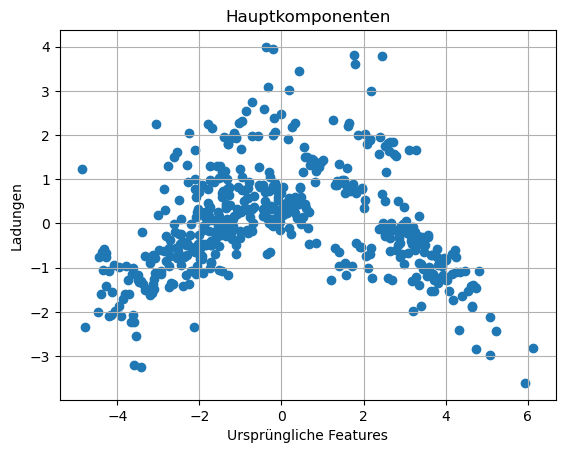

In [46]:
r = 13

VU , D , VT , UD , std_UD , V , std_UDv2 = pca(boston , r)
plt.scatter(UD[0] , UD[1])

plt.title('Hauptkomponenten')
plt.xlabel('Ursprüngliche Features')
plt.ylabel('Ladungen')
plt.grid(True)
plt.show()

c) Korrelationsmatrix berechnen

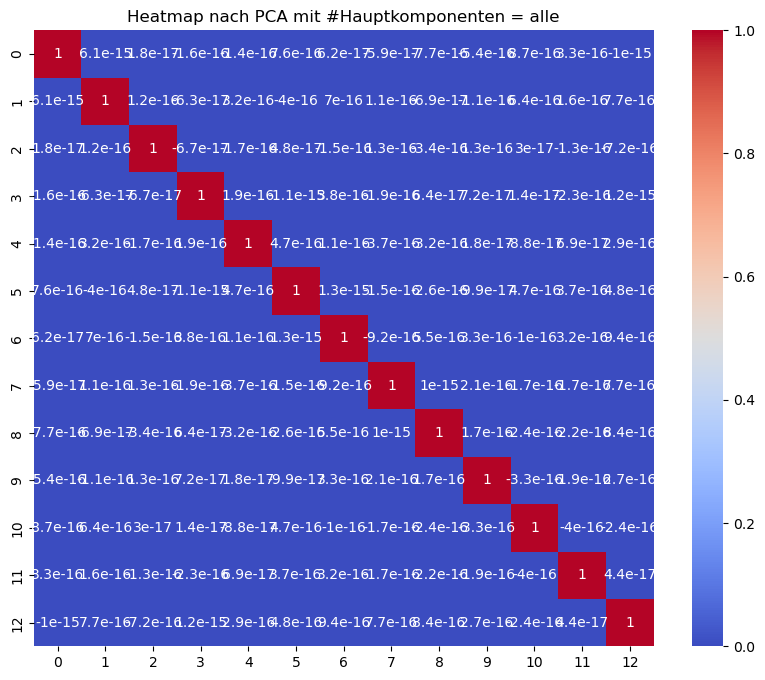

In [47]:
corr_matrix_boston = UD.corr()

corr_matrix_boston

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_boston, annot=True, cmap='coolwarm')

plt.title('Heatmap nach PCA mit #Hauptkomponenten = alle')
plt.show()

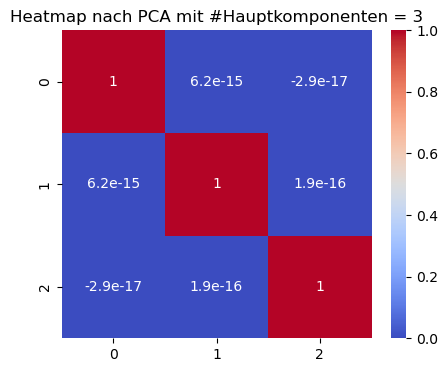

In [48]:
r = 3

VU , D , VT , UD , std_UD , V , std_UDv2 = pca(boston , r)



corr_matrix_boston_3 = UD.corr()

corr_matrix_boston_3

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix_boston_3, annot=True, cmap='coolwarm')

plt.title('Heatmap nach PCA mit #Hauptkomponenten = 3')
plt.show()

e. Stellen Sie die ersten beiden der neuen Variablen als Scatterplot dar (am besten in Pandas-Dataframe importieren). Plotten Sie dabei alle Datenpunkte mit einem Hauspreis oberhalb des Medians aller Hauspreise in einer anderen Farbe als die Datenpunkte unterhalb. Eignen sich die beiden neuen Variablen zur Vorhersage des Hauspreises?

C:\Users\simon\AppData\Local\Temp\ipykernel_22656\2023248934.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  boston_tgt = pd.read_csv(url, sep=' ', skipinitialspace=True, header=None, names=cols,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


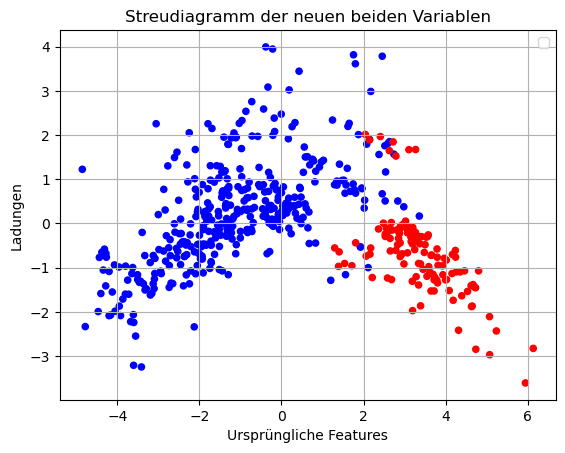

In [53]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
cols = ['TGT']
boston_tgt = pd.read_csv(url, sep=' ', skipinitialspace=True, header=None, names=cols, 
                     index_col=False)

boston_df_tgt = pd.DataFrame(boston_tgt)




UD['greater_median_tgt'] = boston_df_tgt['TGT'].transform(lambda tgt: 'red' if tgt >= boston_df_tgt['TGT'].mean() else 'blue')


UD.plot.scatter(x=0 , y=1 , c='greater_median_tgt')

plt.legend()

red_patch = plt.Line2D([0], [0], marker='o', color='w', label='>= Durchschnitt', markerfacecolor='red', markersize=10)
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='< Durchschnitt', markerfacecolor='blue', markersize=10)
plt.legend(handles=[red_patch, blue_patch])


plt.title('Streudiagramm der neuen beiden Variablen')
plt.xlabel('Ursprüngliche Features')
plt.ylabel('Ladungen')
plt.grid(True)
plt.show()


Man kann noch nicht sicher erkennen ob die beiden neuen Variablen geignet für die Vorhersage des Hauspreises sind. Da